In [2]:
import os

exp_dir = f"results/"

os.makedirs(f"{exp_dir}/plots", exist_ok=True)

In [6]:
# latency cdfs data

import json
from collections import defaultdict
from datetime import datetime, timezone, timedelta

timings = defaultdict(lambda: defaultdict(list)) # mapping from config json to latency list

for config_dir in os.listdir(exp_dir):    
    if config_dir == "plots":
        continue
    print(config_dir)
    
    # read in configuration.json file and parse
    with open(f"{exp_dir}/{config_dir}/configuration.json", "r") as config_file:
        config = config_file.read()
        config = json.dumps(json.loads(config))
    
#     for repeat in os.listdir(config):
#     if repeat.startswith("repeat"): 
    # read logs of docker-bench
    for bencher in os.listdir(f"{exp_dir}/{config_dir}/logs"):
        if bencher.startswith("bencher"):
            with open(f"{exp_dir}/{config_dir}/logs/{bencher}", "r") as log:
                for line in log.readlines():
                    j = line
                    try:
                        output = json.loads(j)
                    except ValueError:
                        continue

                    start_secs = output["start"]["secs_since_epoch"]
                    start_nanos = output["start"]["nanos_since_epoch"]
                    start = datetime(1970, 1, 1, tzinfo=timezone.utc) + timedelta(seconds=start_secs,microseconds=start_nanos/1000)

                    end_secs = output["end"]["secs_since_epoch"]
                    end_nanos = output["end"]["nanos_since_epoch"]
                    end = datetime(1970, 1, 1, tzinfo=timezone.utc) + timedelta(seconds=end_secs,microseconds=end_nanos/1000)

                    latency = end - start
                    timings[config]["starts"].append(start)
                    timings[config]["ends"].append(end)
                    timings[config]["latencies"].append((latency / timedelta(microseconds=1))/1000.)
    print("datapoints:", len(timings[config]["latencies"]))
print("loaded", len(timings))

recetcd-3nodes-2benchers
datapoints: 200000
etcd-3nodes-2benchers
datapoints: 200000
loaded 2


In [9]:
import pandas as pd

for (k, v) in timings.items():
    print(k)
    print("Latencies")
    series = pd.Series(v["latencies"])
    print(series.describe())
    print()

{"image_name": "jeffas/recetcd:latest", "bench_type": "PutRange", "cluster_size": 3, "extra_args": ""}
Latencies
count    200000.000000
mean          5.952435
std           3.538306
min           0.489000
25%           3.405000
50%           5.463000
75%           7.530000
max          24.469000
dtype: float64

{"image_name": "quay.io/coreos/etcd", "bench_type": "PutRange", "cluster_size": 3, "extra_args": ""}
Latencies
count    200000.000000
mean        118.222689
std          38.004899
min          10.370000
25%          87.346750
50%         123.266000
75%         145.287250
max         274.357000
dtype: float64



In [35]:
# latency scatter plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_scatter(bench_type, cluster_size, show_sync = True):
    f = plt.figure()
    f.set_figwidth(6.4 * 1)
    f.set_figheight(4.8 * 1)

    for (k, v) in timings.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            print("Skipping", config["bench_type"])
            continue

        if config["cluster_size"] == cluster_size:
            if config["image_name"] == "quay.io/coreos/etcd":
                image = "etcd"
            elif config["image_name"] == "jeffas/eckd":
                image = "eckd"
            elif "jeffas/recetcd" in config["image_name"]:
                image = "recetcd"
            else:
                print("unmatched image name:", config["image_name"])

            if "--sync" in config["extra_args"] and not show_sync:
                continue
                
            sync = " sync" if "--sync" in config["extra_args"] else ""
            
            starts = v["starts"]
            start = starts[0]
            starts = [(s - start) / timedelta(seconds=1) for s in starts]
            latencies = v["latencies"]

            plt.scatter(starts, latencies, label=f"{image} x{cluster_size}{sync}")

    plt.grid()
    plt.title(f"Latency Scatter ({bench_type})")
    plt.xlabel("Time from start (s)")
    plt.ylabel("Request duration (ms)")
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/latency-scatter-{lower_bench_type}.pdf")

No handles with labels found to put in legend.


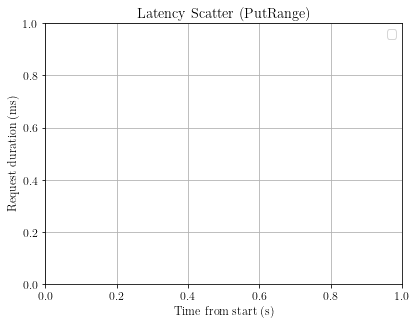

In [30]:
plot_scatter("PutRange", 1)

In [ ]:
plot_scatter("PutSingle", 1)

In [ ]:
plot_scatter("PutRandom", 1)

<ipython-input-35-f317a84498a7>:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{exp_dir}/plots/latency-scatter-{lower_bench_type}.pdf")
<ipython-input-35-f317a84498a7>:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{exp_dir}/plots/latency-scatter-{lower_bench_type}.pdf")
/nix/store/9qfh7x7y9iiyyyzfv0zrdx53mz59wr7h-python3.9-ipython-7.24.1/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


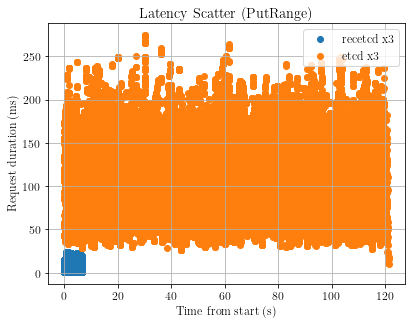

In [36]:
plot_scatter("PutRange", 3, show_sync=False)

In [ ]:
plot_scatter("PutSingle", 3)

In [ ]:
plot_scatter("PutRandom", 3)

In [ ]:
plot_scatter("PutRange", 5)

In [ ]:
plot_scatter("PutSingle", 5)

In [ ]:
plot_scatter("PutRandom", 5)

In [42]:
# latency cdfs plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_cdf(bench_type, cluster_size, show_sync = True):

    f = plt.figure()
    f.set_figwidth(6.4 * 1)
    f.set_figheight(4.8 * 1)

    for (k, v) in timings.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            continue

        if config["cluster_size"] == cluster_size:
            if config["image_name"] == "quay.io/coreos/etcd":
                image = "etcd"
            elif config["image_name"] == "jeffas/eckd":
                image = "eckd"
            elif "jeffas/recetcd" in config["image_name"]:
                image = "recetcd"
            else:
                print("unmatched image name:", config["image_name"])

            if "--sync" in config["extra_args"] and not show_sync:
                continue
                
            sync = " sync" if "--sync" in config["extra_args"] else ""

            latencies = v["latencies"]
            latencies.sort()
            size = len(latencies)
            ys = np.array(range(size))/ float(size)

            plt.plot(latencies, ys, label=f"{image} x{cluster_size}{sync}")

    plt.grid()
    plt.title(f"Latency CDF ({bench_type})")
    plt.xlabel("Request duration (ms)")
    plt.ylabel("Probability")
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/latency-cdf-{lower_bench_type}.pdf")

In [ ]:
plot_cdf("PutRange", 1)

In [ ]:
plot_cdf("PutSingle", 1)

In [ ]:
plot_cdf("PutRandom", 1)

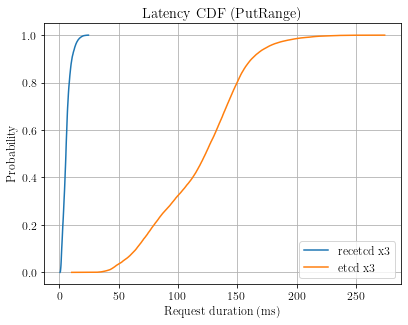

In [43]:
plot_cdf("PutRange", 3, show_sync = False)

In [ ]:
plot_cdf("PutSingle", 3, show_sync = False)

In [ ]:
plot_cdf("PutRandom", 3, show_sync = False)

In [ ]:
plot_cdf("PutRange", 5, show_sync = False)

In [ ]:
plot_cdf("PutSingle", 5)

In [ ]:
plot_cdf("PutRandom", 5)

In [ ]:
# get cpu and mem data

import json
from collections import defaultdict
from datetime import datetime, timezone, timedelta

cpu_usage = {} # mapping from config json to cpu usage list
mem_usage = {} # mapping from config json to mem usage list

for config in config_dirs:
    print("processing", config)
    c = json.dumps(json.loads("".join(open(f"{exp_dir}/{config}/configuration.json").readlines())))

    for repeat in os.listdir(f"{exp_dir}/{config}"):
        if repeat.startswith("repeat"):
            with open(f"{exp_dir}/{config}/{repeat}/logs/docker-bench.log", "r") as log:
                for line in log.readlines():
                    j = line.split()[1]
                    try:
                        output = json.loads(j)
                    except ValueError:
                        continue

                    start_secs = output["start"]["secs_since_epoch"]
                    start_nanos = output["start"]["nanos_since_epoch"]
                    start = datetime(1970, 1, 1) + timedelta(seconds=start_secs,microseconds=start_nanos/1000)
                    break
                    
            # read metrics of node*
            with open(f"{exp_dir}/{config}/{repeat}/metrics/docker-node1.stat", "r") as stats:
                times = []
                cpus = []
                mems = []
                for line in stats.readlines():
                    sp = line.split()
                    
                    dt = sp[0]
                    dt = dt.replace("+00:00","")
                    dot = dt.find(".")
        
                    dt = datetime.fromisoformat(dt[:dot+7])
             
                    times.append(dt-start)
                    j = sp[1]
                    
                    output = json.loads(j)
                    
                    # from https://github.com/docker/cli/blob/bf4a96e5640f86860e68622d2498039d86bf5714/cli/command/container/stats_helpers.go#L166
                    cpu_percent = 0
                    cpu_delta = output["cpu_stats"]["cpu_usage"]["total_usage"] - output["precpu_stats"]["cpu_usage"]["total_usage"]
                    system_delta = output["cpu_stats"]["system_cpu_usage"] - (output["precpu_stats"]["system_cpu_usage"] or 0)
                    online_cpus = output["cpu_stats"]["online_cpus"]
                    if online_cpus == 0:
                        print("no cpus!!")
                    if system_delta > 0 and cpu_delta > 0:
                        cpu_percent = (float(cpu_delta) / float(system_delta)) * float(online_cpus) * 100.0
                    cpus.append(cpu_percent)
                    
                    
                    mem = output["memory_stats"]["usage"]
                    mems.append(mem)
                
                cpu_usage[c] = (times, cpus)
                mem_usage[c] = (times, mems)

In [ ]:
# cpu usage plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_cpu(bench_type, cluster_size):

    f = plt.figure()
    f.set_figwidth(6.4 * 1)
    f.set_figheight(4.8 * 1)

    for (k, v) in cpu_usage.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            continue

        if config["cluster_size"] == cluster_size:
            if config["image_name"] == "quay.io/coreos/etcd":
                image = "etcd"
            elif config["image_name"] == "jeffas/eckd":
                image = "eckd"
            elif config["image_name"] == "jeffas/recetcd":
                image = "recetcd"
            else:
                print("unmatched image name:", config["image_name"])

            sync = " sync" if "--sync" in config["extra_args"] else ""

            xs = [x.total_seconds() for x in v[0]]
            ys = v[1]

            plt.plot(xs, ys, label=f"{image} x{cluster_size}{sync}")

    plt.grid()
    plt.title(f"CPU Usage ({bench_type})")
    plt.xlabel("Time since start (s)")
    plt.ylabel("CPU usage (\%)")
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/cpu-usage-{lower_bench_type}.pdf")

In [ ]:
plot_cpu("PutRange", 1)

In [ ]:
plot_cpu("PutSingle", 1)

In [ ]:
plot_cpu("PutRandom", 1)

In [ ]:
plot_cpu("PutRange", 3)

In [ ]:
plot_cpu("PutSingle", 3)

In [ ]:
plot_cpu("PutRandom", 3)

In [ ]:
plot_cpu("PutRange", 5)

In [ ]:
plot_cpu("PutSingle", 5)

In [ ]:
plot_cpu("PutRandom", 5)

In [ ]:
# mem usage plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_mem(bench_type, cluster_size):
    f = plt.figure()
    f.set_figwidth(6.4 * 1)
    f.set_figheight(4.8 * 1)

    for (k, v) in mem_usage.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            continue

        if config["cluster_size"] == cluster_size:
            if config["image_name"] == "quay.io/coreos/etcd":
                image = "etcd"
            elif config["image_name"] == "jeffas/eckd":
                image = "eckd"
            elif config["image_name"] == "jeffas/recetcd":
                image = "recetcd"
            else:
                print("unmatched image name:", config["image_name"])

            sync = " sync" if "--sync" in config["extra_args"] else ""

            xs = [x.total_seconds() for x in v[0]]
            ys = np.array(v[1]) / 1_000_000

            plt.plot(xs, ys, label=f"{image} x{cluster_size}{sync}")

    plt.grid()
    plt.title(f"Memory Usage ({bench_type})")
    plt.xlabel("Time since start (s)")
    plt.ylabel("Memory usage (MB)")
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/mem-usage-{lower_bench_type}.pdf")

In [ ]:
plot_mem("PutRange", 1)

In [ ]:
plot_mem("PutSingle", 1)

In [ ]:
plot_mem("PutRandom", 1)

In [ ]:
plot_mem("PutRange", 3)

In [ ]:
plot_mem("PutSingle", 3)

In [ ]:
plot_mem("PutRandom", 3)

In [ ]:
plot_mem("PutRange", 5)

In [ ]:
plot_mem("PutSingle", 5)

In [ ]:
plot_mem("PutRandom", 5)